# Setup

To run this notebook, a few setup steps are required. Follow along step by step:

1. **Install dependencies**  
   Once the library is cloned, install the required dependencies.

In [34]:
import subprocess

result = subprocess.run(
    ["pip", "install", "-r", "requirements.txt"],
    capture_output=True,
    text=True
)

if "Requirement already satisfied" in result.stdout:
    print("All requirements satisfied")
else:
    print(result.stdout)


All requirements satisfied


2. **Providion the datasets**  
   You’ll then need to access and download the necessary datasets for this chapter.

In [35]:
%run src/download_localization.py --task localization

Files Downloaded:   0%|          | 0/53 [00:00<?, ?file/s]

Files Downloaded:   0%|          | 0/2 [00:00<?, ?file/s]

In [94]:
import jax
import optax

from src.utils.context import assets
from src.utils.display import display

from src.localization.dataset import Dataset
from src.localization.dataset.builder import DatasetBuilder
from src.localization.dataset.utils import (
    get_dataset,
    count_unique_proteins,
)

from src.localization.model import (
    LocalizationModel,
    Encoder,
    Decoder,
    ResnetBlock,
    Upsample,
    VectorQuantizer,
    ClassificationHead,
)

from src.localization.train import (
    train,
    train_step,
)

from src.localization.inspect.reconstruction import show_reconstruction
from src.localization.inspect.metrics import (
    plot_losses,
    plot_perplexity,
)

from src.localization.inspect.embeddings.utils import (
    get_frame_embeddings,
    aggregate_proteins,
    aggregate_localizations,
    cluster_feature_spectrums,
)

from src.localization.inspect.embeddings.clustering import (
    calculate_projection,
    plot_projection,
)

from src.localization.inspect.embeddings.feature_spectrum import (
    plot_encoding_corr_heatmap,
    plot_stacked_histrograms,
)


In [101]:
# Toggle JAX_DISABLE_JIT to True for easier debugging
%env JAX_DISABLE_JIT=False

try:
  import src
except ImportError as exc:
  # NOTE: Packages installed in editable mode are not immediately
  #       recognized by Colab (https://stackoverflow.com/a/63312333).
  import site
  site.main()
  import src


env: JAX_DISABLE_JIT=False


A:\learning\project\protein_localization


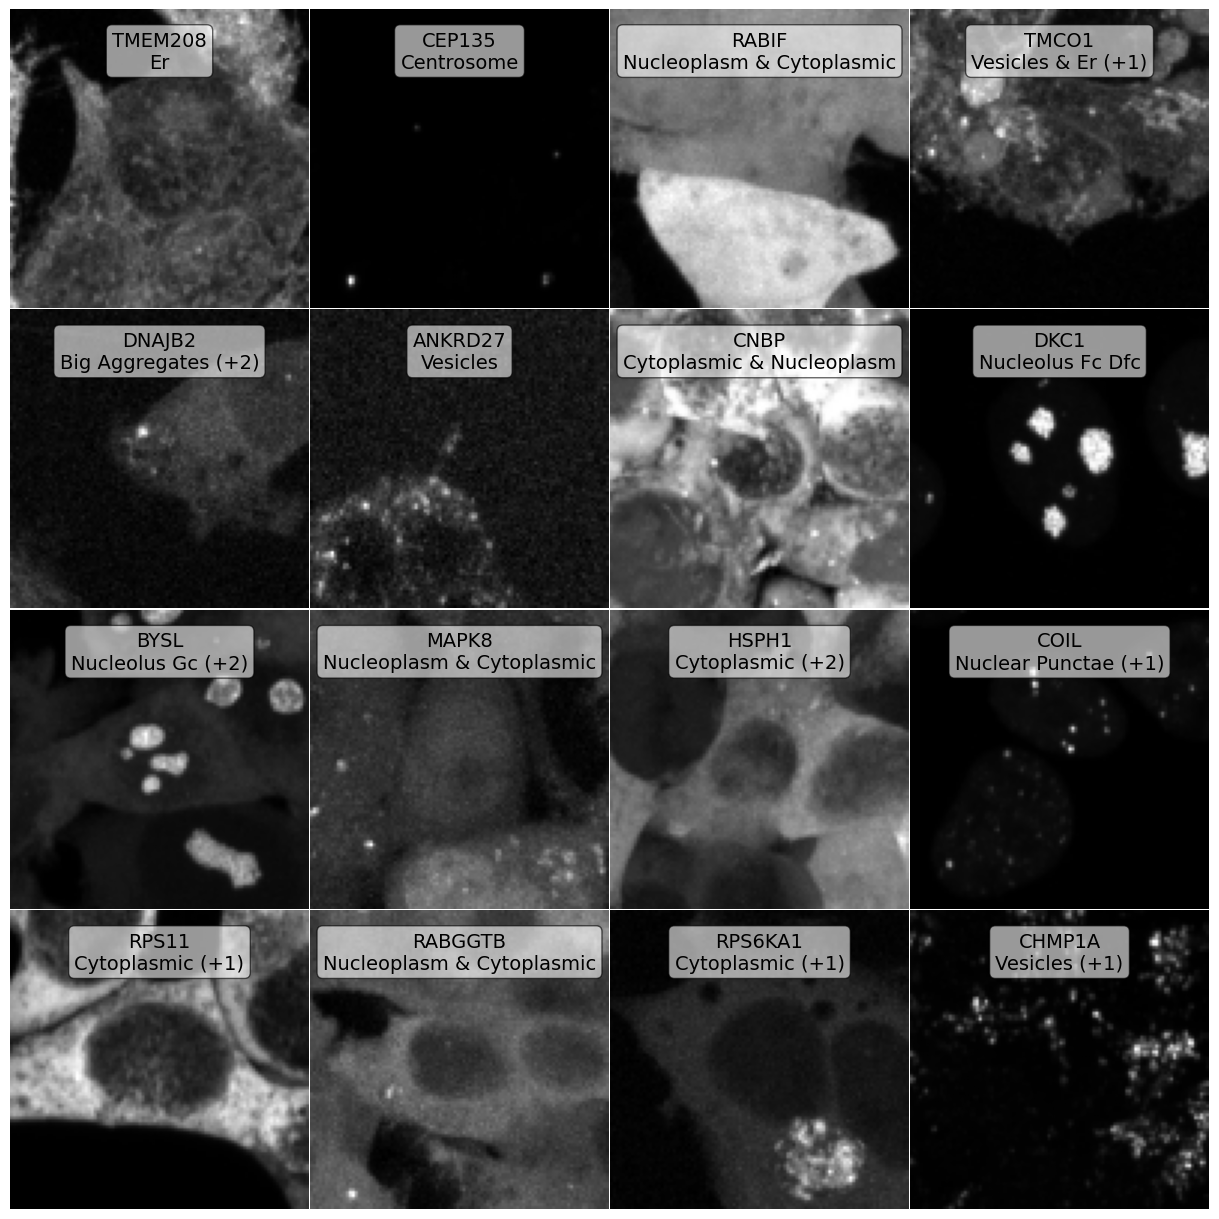

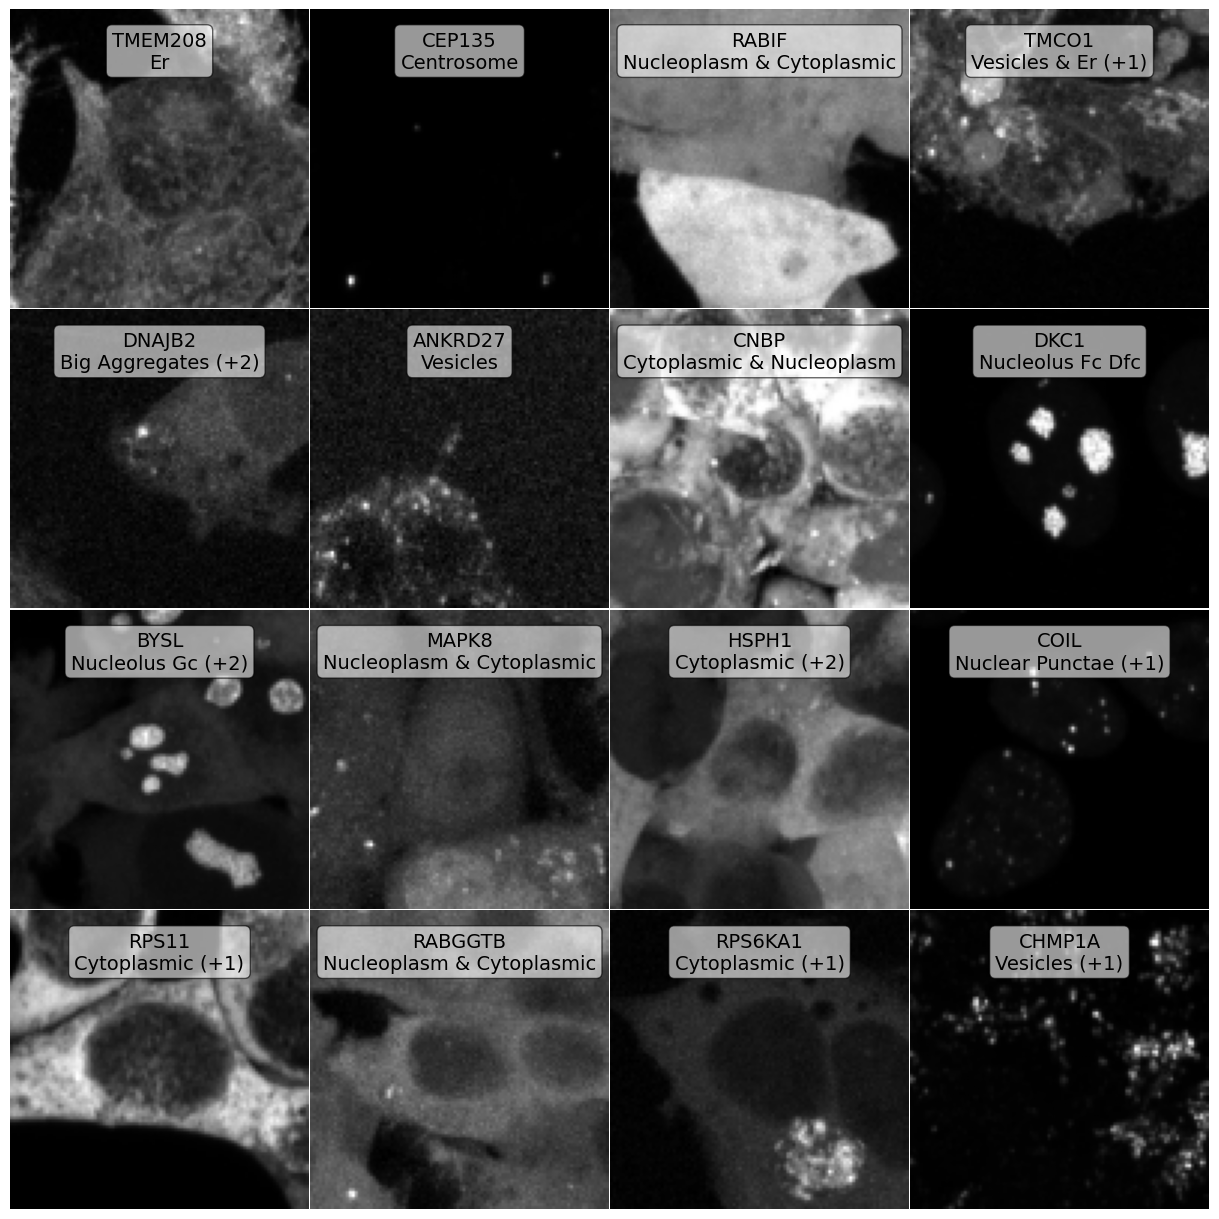

In [38]:
rng = jax.random.PRNGKey(42)
rng, rng_frames = jax.random.split(rng, 2)

dataset = get_dataset(data_path=assets("localization/datasets"))
n_frames = 16
dataset.plot_random_frames(n=n_frames, rng=rng_frames)

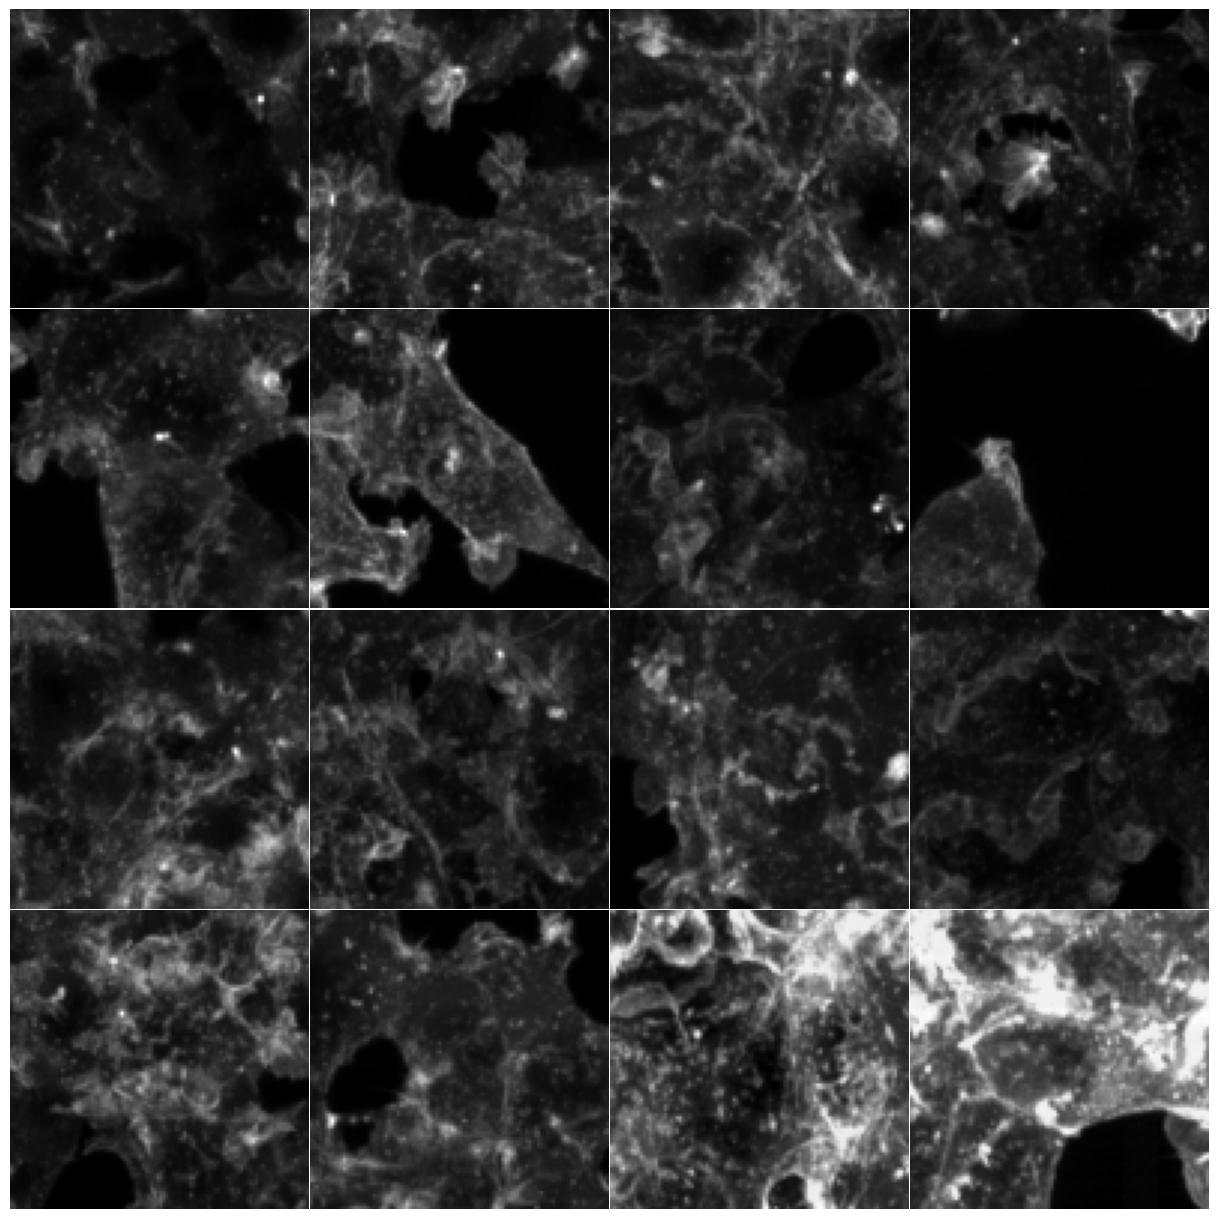

In [39]:
selected_protein = "ACTB"
dataset.plot_random_frames(
  n=n_frames, with_labels=False, rng=rng_frames, gene_symbols=[selected_protein]
);

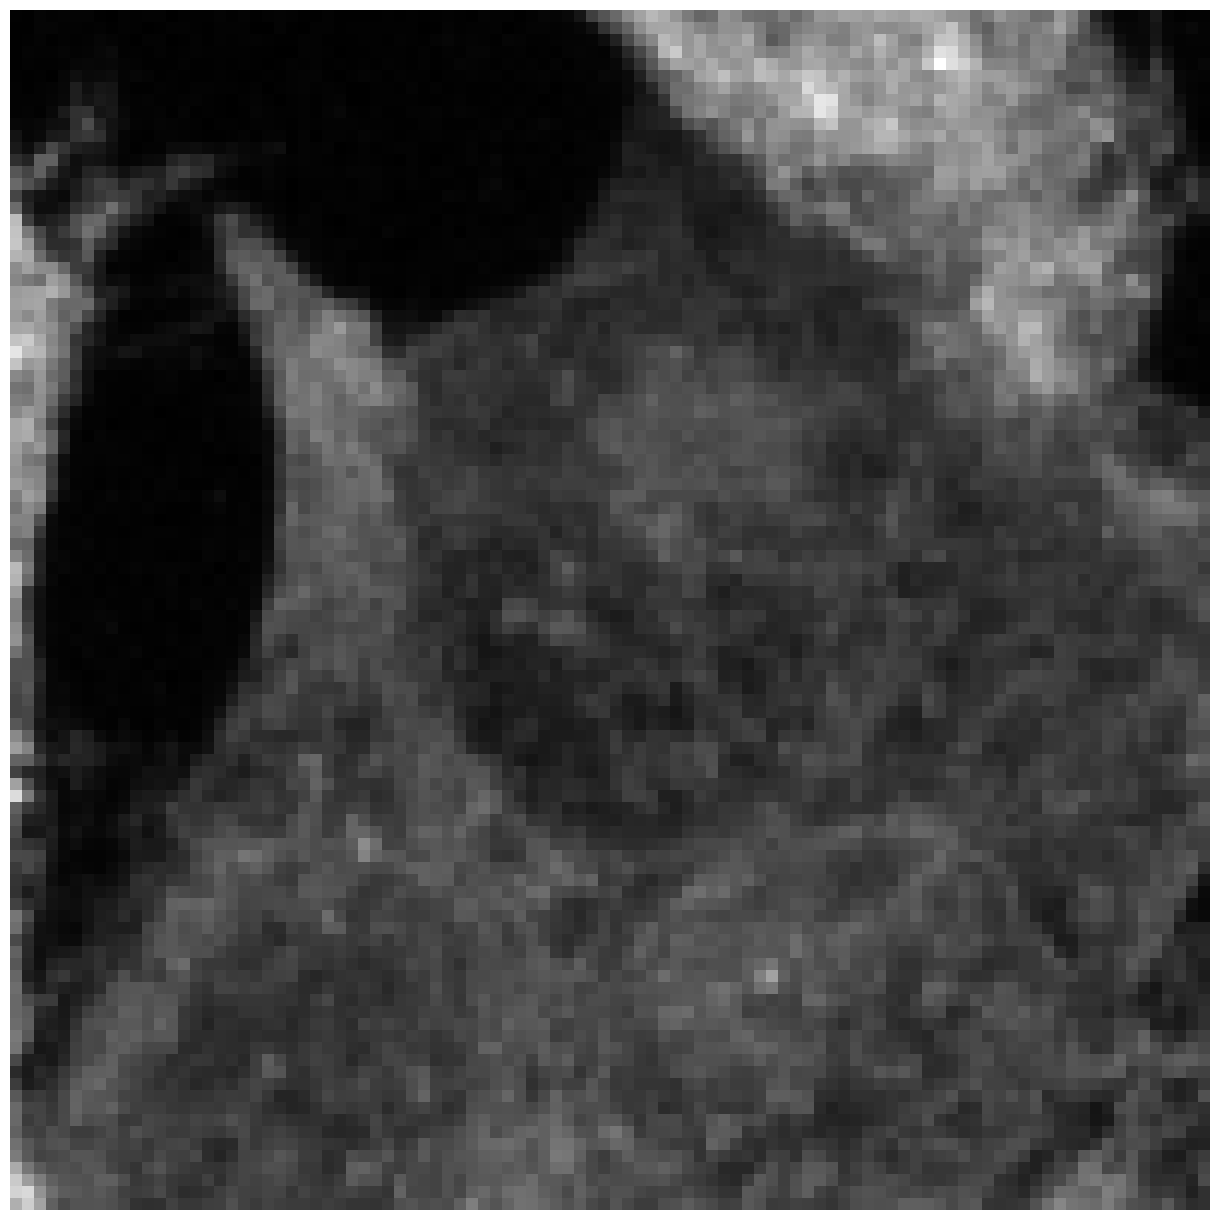

In [40]:
dataset.plot_random_frames(n=1, with_labels=False, rng=rng_frames);

### 6.3.4. Implementing a DatasetBuilder Class


#### 6.3.4.1. Building a First Dataset Instance


In [41]:
builder = DatasetBuilder(data_path=assets("localization/datasets"))

rng, rng_dataset = jax.random.split(rng, 2)
dataset: dict[str, Dataset] = builder.build(
  rng=jax.random.PRNGKey(42),
  splits={"train": 0.80, "valid": 0.10, "test": 0.10},
  exclusive_by="fov_id",
  n_proteins=50,
)

A:\learning\project\protein_localization


## 6.4. Building a Prototype Model
### 6.4.1. Defining the LocalizationModel


In [109]:
from src.utils.display import display

display([LocalizationModel])

### 6.4.2. The Encoder: Processing Input Images


In [78]:
display([Encoder, ResnetBlock])

### 6.4.3. The VectorQuantizer: Discretizing the Embeddings


In [44]:
display([VectorQuantizer])

In [45]:
display([VectorQuantizer.__call__])

In [46]:
display([VectorQuantizer.quantize, VectorQuantizer.calculate_distances])

#### 6.4.3.1. Calculating VQ-VAE–Specific Losses


In [47]:
display([VectorQuantizer.compute_losses])

#### 6.4.3.2. Using Perplexity to Measure Codebook Use


In [48]:
display([VectorQuantizer.calculate_perplexity])

#### 6.4.3.3. Using the Straight-Through Estimator


In [49]:
display([VectorQuantizer.get_straight_through_estimator])

### 6.4.4. Decoder: Decoding the Discretized Embeddings Back to Images


In [50]:
display([Decoder, Upsample])

### 6.4.5. ClassificationHead: A Simple but Crucial Module


In [51]:
display([ClassificationHead])

### 6.4.6. Setting Up Model Training


In [52]:
display([train])

In [53]:
display([Dataset.get_batches])

In [54]:

display([train_step])

## 6.5. Training with a Small Image Set


In [55]:
rng, rng_dataset = jax.random.split(rng, 2)

dataset_splits = DatasetBuilder(
  data_path=assets("localization/datasets")
).build(
  rng=rng_dataset,
  splits={"train": 0.80, "valid": 0.10, "test": 0.10},
  n_proteins=50,
)

A:\learning\project\protein_localization


In [56]:
model = LocalizationModel(
  num_classes=count_unique_proteins(dataset_splits),
  embedding_dim=64,
  num_embeddings=512,
  commitment_cost=0.25,
  dropout_rate=0.45,
  classification_head_layers=2,
)

In [57]:
rng, rng_init, rng_train = jax.random.split(rng, 3)

state, metrics = train(
  state=model.create_train_state(
    rng=rng_init,
    dummy_input=dataset_splits["train"].get_dummy_input(),
    tx=optax.adam(0.001),
  ),
  rng=rng_train,
  dataset_splits=dataset_splits,
  num_epochs=10,
  batch_size=256,
  classification_weight=1,
  eval_every=1,
  store_path=assets("localization/models/small"),
)

A:\learning\project\protein_localization


### 6.5.1. Inspecting Image Reconstruction


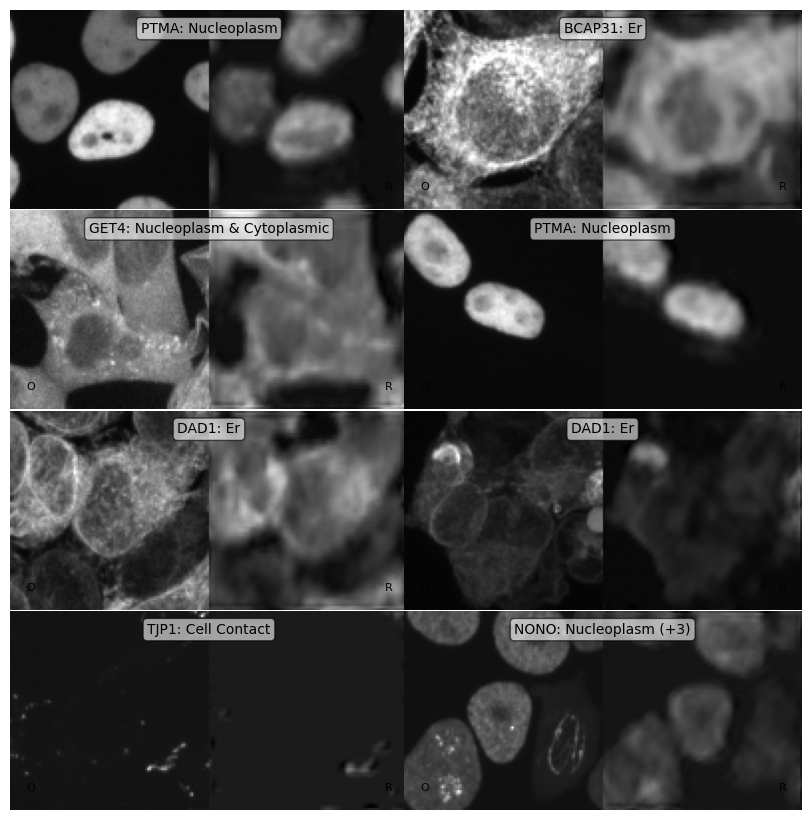

In [58]:
show_reconstruction(dataset_splits["valid"], state, n=8, rng=rng_frames);

### 6.5.2. Evaluation Metrics over Epochs


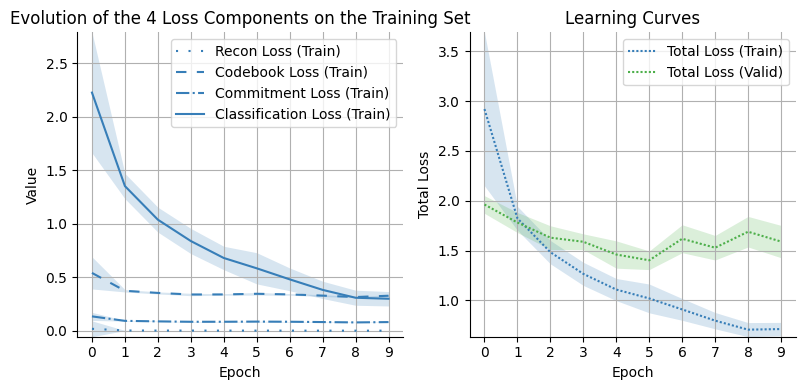

In [59]:
plot_losses(metrics);

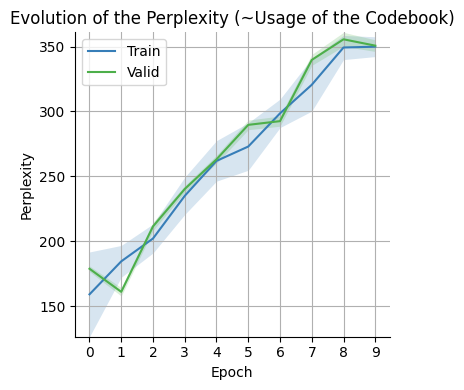

In [60]:
plot_perplexity(metrics);

### 6.5.3. Model without Classification Task


In [61]:
state_alt, metrics_alt = train(
  state=model.create_train_state(
    rng=rng_init,
    dummy_input=dataset_splits["train"].get_dummy_input(),
    tx=optax.adam(0.001),
  ),
  rng=rng_train,
  dataset_splits=dataset_splits,
  num_epochs=10,
  batch_size=256,
  classification_weight=0,  # i.e. the protein id are ignored
  eval_every=1,
  store_path=assets("localization/models/small_alt"),
)

A:\learning\project\protein_localization


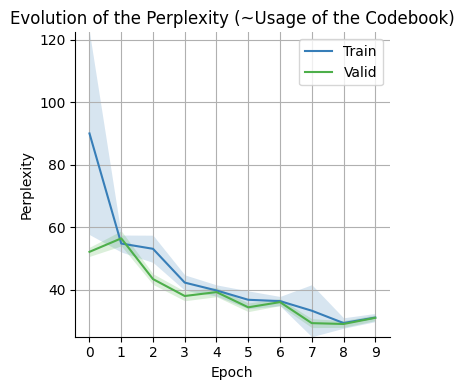

In [62]:
plot_perplexity(metrics_alt);

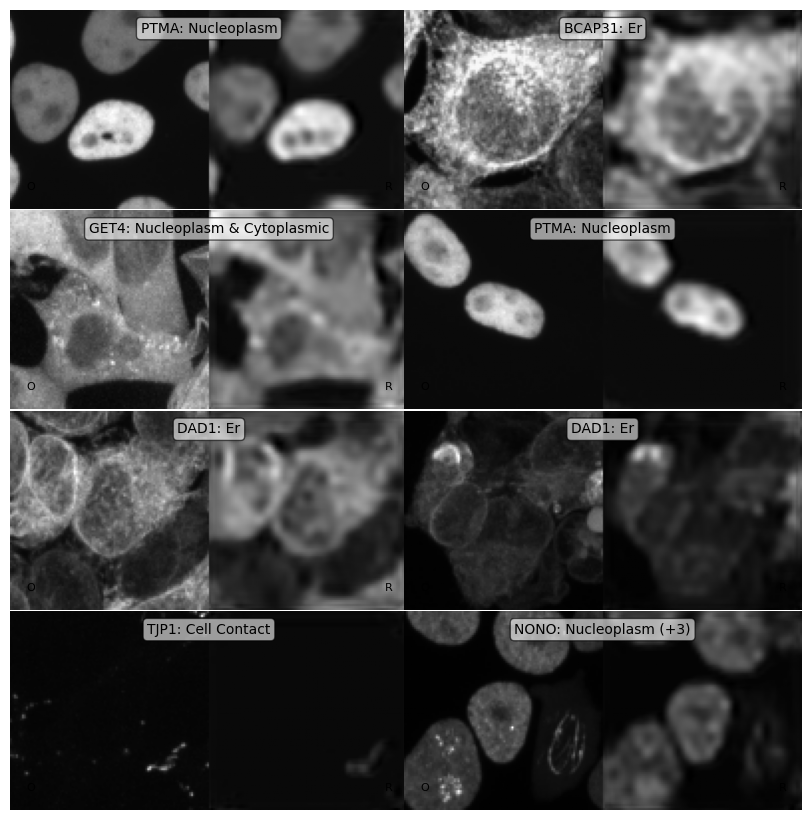

In [63]:
show_reconstruction(dataset_splits["valid"], state_alt, n=8, rng=rng_frames);

## 6.6. Understanding the Model
### 6.6.1. Understanding Localization Clustering


In [64]:
display([get_frame_embeddings])

c:\Users\Amrithya\miniconda3\envs\protein_conda\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Amrithya\miniconda3\envs\protein_conda\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


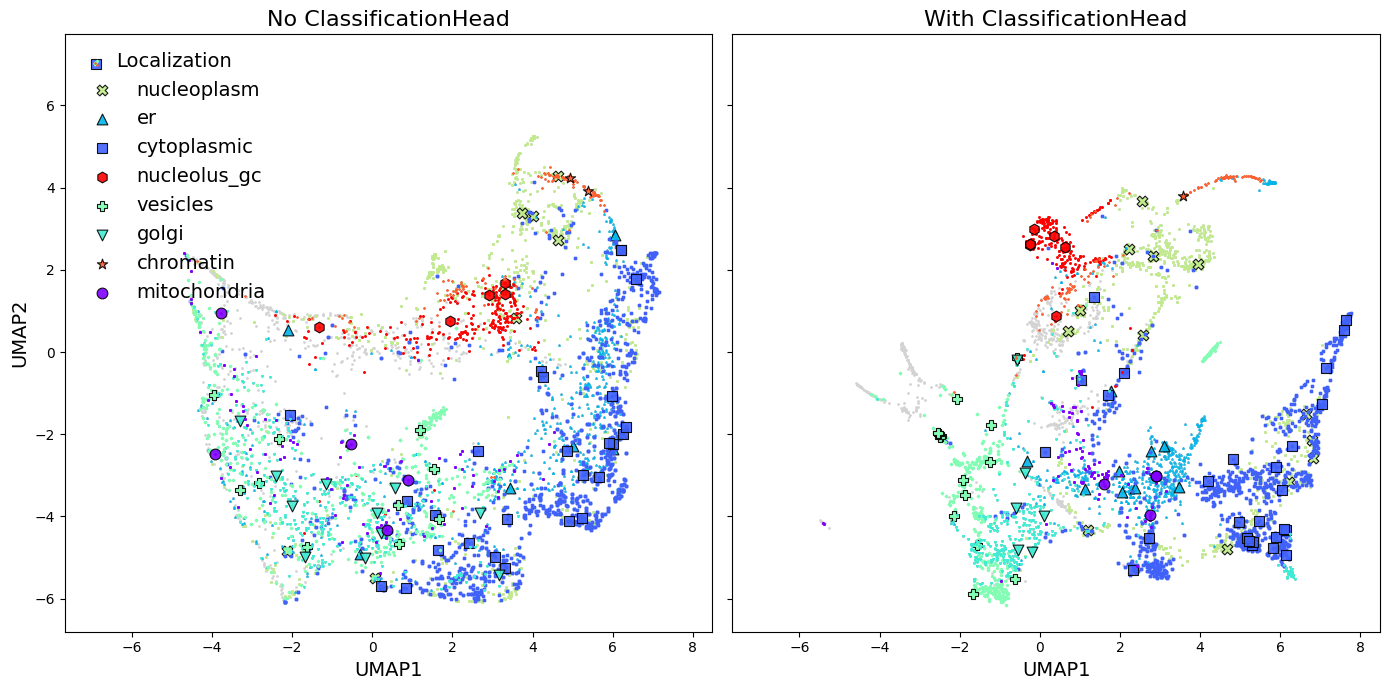

In [65]:
frame_embeddings = {}
for name, s in zip(["no_head", "with_head"], [state_alt, state]):
  frame_embeddings[name] = get_frame_embeddings(s, dataset_splits["valid"])

projection = calculate_projection(frame_embeddings)
plot_projection(
  projection,
  dataset_splits["valid"],
  titles=["No ClassificationHead", "With ClassificationHead"],
);

### 6.6.2. Inspecting Feature Spectrums


In [66]:
display([cluster_feature_spectrums])

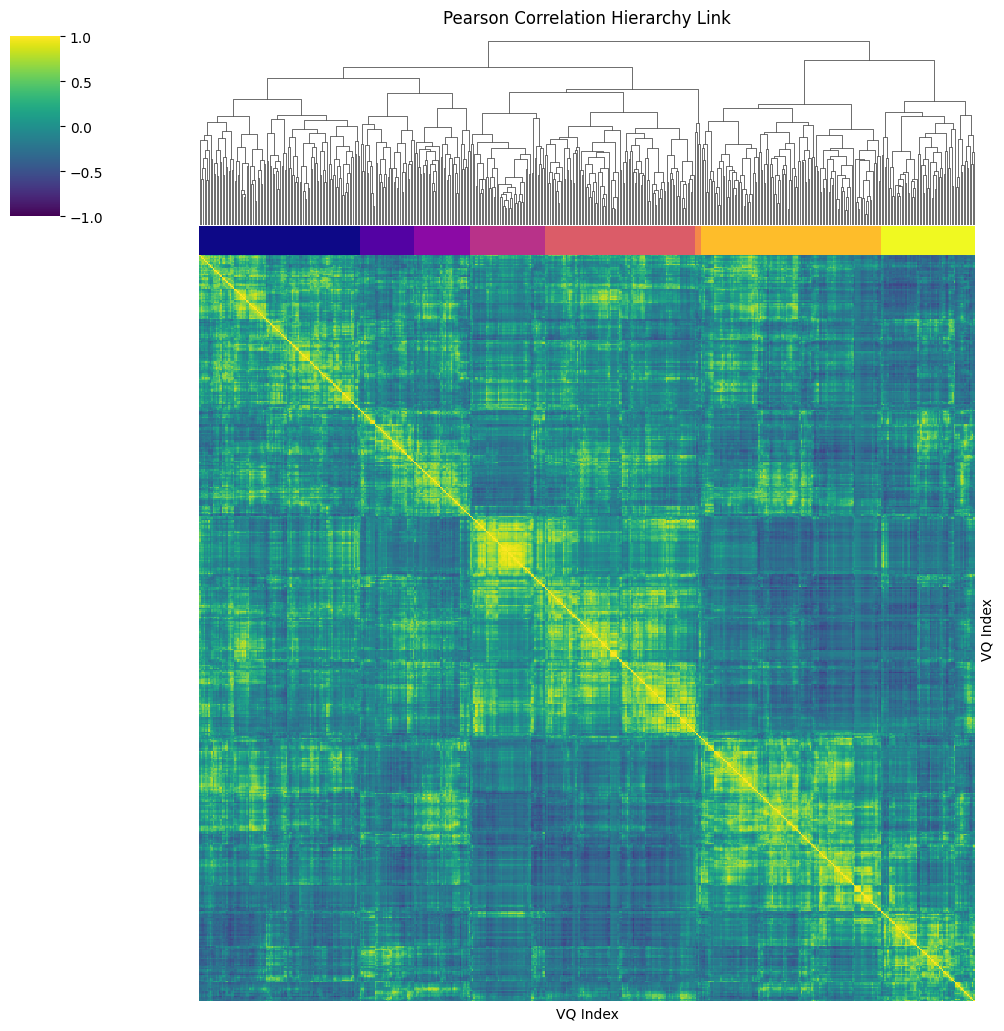

In [67]:
protein_ids, protein_histograms = aggregate_proteins(
  dataset_splits["valid"], **frame_embeddings["with_head"]
)
corr_idx_idx, tree, encoding_clusters = cluster_feature_spectrums(
  protein_histograms, n_clusters=8
)
plot_encoding_corr_heatmap(corr_idx_idx, tree, encoding_clusters);

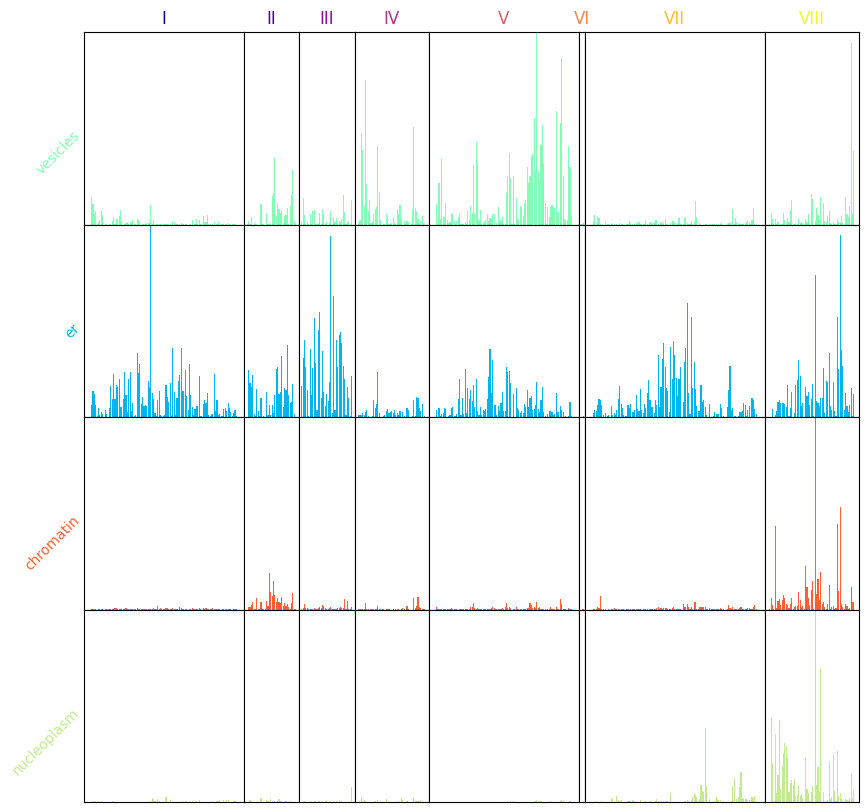

In [68]:
localizations, localization_histograms = aggregate_localizations(
  dataset_splits["valid"], protein_ids, protein_histograms
)
plot_stacked_histrograms(
  localizations, localization_histograms, tree, encoding_clusters
);

## 6.7. Improving the Model
### 6.7.1. Scaling Up the Data


In [69]:
dataset_splits = DatasetBuilder(
  data_path=assets("localization/datasets")
).build(
  rng=rng_dataset,
  splits={"train": 0.80, "valid": 0.10, "test": 0.10},
  n_proteins=500,  # a larger number of proteins
)

model = LocalizationModel(
  num_classes=count_unique_proteins(dataset_splits),
  embedding_dim=64,
  num_embeddings=512,
  commitment_cost=0.25,
  dropout_rate=0.45,
  classification_head_layers=2,
)

state, metrics = train(
  state=model.create_train_state(
    rng=rng_init,
    dummy_input=dataset_splits["train"].get_dummy_input(),
    tx=optax.adam(0.001),
  ),
  rng=rng_train,
  dataset_splits=dataset_splits,
  num_epochs=10,
  batch_size=256,
  classification_weight=1,
  eval_every=1,
  store_path=assets("localization/models/large"),
)

A:\learning\project\protein_localization
A:\learning\project\protein_localization


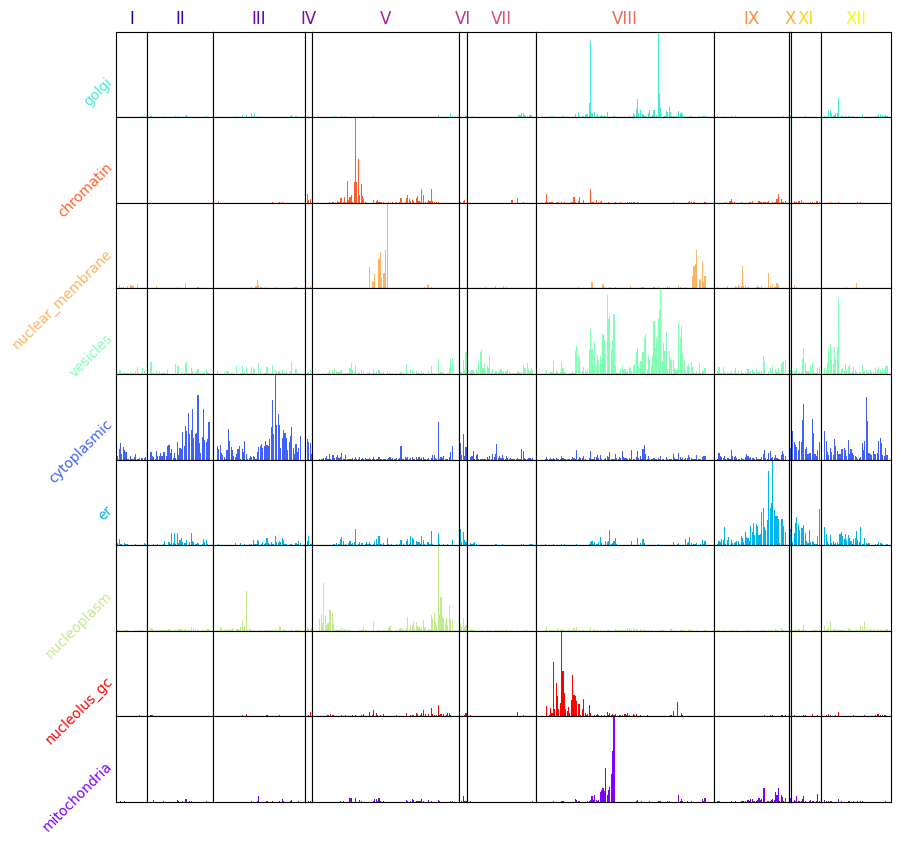

In [70]:
frame_embeddings = get_frame_embeddings(state, dataset_splits["valid"])
protein_ids, protein_histograms = aggregate_proteins(
  dataset_splits["valid"], **frame_embeddings
)
_, tree, encoding_clusters = cluster_feature_spectrums(
  protein_histograms, n_clusters=12
)
localizations, localization_histograms = aggregate_localizations(
  dataset_splits["valid"], protein_ids, protein_histograms
)
plot_stacked_histrograms(
  localizations, localization_histograms, tree, encoding_clusters
);

c:\Users\Amrithya\miniconda3\envs\protein_conda\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


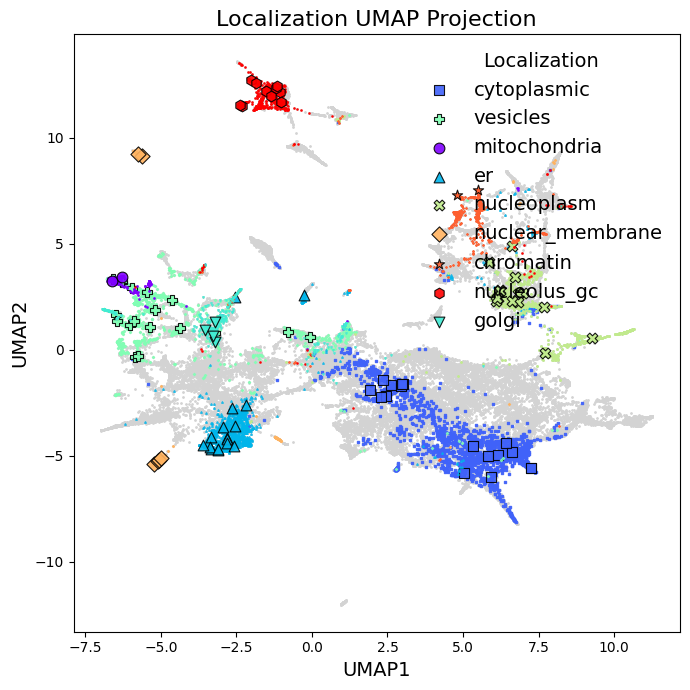

In [71]:
projection = calculate_projection(frame_embeddings)
plot_projection(
  projection,
  dataset_splits["valid"],
  subset_mode="single",  # Only show frames with single localization
  titles=["Localization UMAP Projection"],
);